## Compare with model results and interpretability from DeepMol

Load the dataset from a CSV

In [30]:
from deepmol.compound_featurization import TwoDimensionDescriptors
from collections import Counter
from deepmol.datasets import SmilesDataset
from deepmol.loaders.loaders import CSVLoader
import pandas as pd
from deepmol.imbalanced_learn import RandomUnderSampler
from deepmol.splitters.splitters import SingletaskStratifiedSplitter
from copy import deepcopy
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from deepmol.metrics import Metric
from sklearn.metrics import roc_auc_score, accuracy_score
from deepmol.feature_importance import ShapValues

In [31]:
ds = pd.read_csv('data/tox21.csv')
ds.dropna(subset=['SR-p53'],inplace=True)
ds.fillna(0, inplace=True)
ds.drop('mol_id', axis=1, inplace=True)
ds.shape

(6774, 13)

In [32]:




ds.to_csv("data/deepmol_dataset.csv", sep=',', index=True,index_label="id", encoding='utf-8')

loader = CSVLoader(dataset_path='data/deepmol_dataset.csv',
                   smiles_field='smiles',
                   id_field='id',
                   labels_fields=['SR-p53'],
                   features_fields=['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD','NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP'],
                   shard_size=6774,
                   mode='auto')

In [33]:
dataset = loader.create_dataset()
dataset.get_shape()

[21:40:09] WARNING: not removing hydrogen atom without neighbors


2024-05-17 21:40:10,645 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!
2024-05-17 21:40:10,749 — INFO — Mols_shape: (6774,)
2024-05-17 21:40:10,751 — INFO — Features_shape: (6774, 11)
2024-05-17 21:40:10,752 — INFO — Labels_shape: (6774,)


((6774,), (6774, 11), (6774,))

In [34]:
Counter(dataset.y)

Counter({0.0: 6351, 1.0: 423})

In [35]:
from deepmol.imbalanced_learn import RandomUnderSampler

d3 = deepcopy(dataset)
sampler = RandomUnderSampler(sampling_strategy=0.75, random_state=123, replacement=True)
d3 = sampler.sample(d3)

Counter(d3.y)   

Counter({0.0: 564, 1.0: 423})

In [36]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=d3, frac_train=0.7,
                                                                             frac_valid=0.15, frac_test=0.15)

In [37]:
rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

SklearnModel(model=RandomForestClassifier(),
             model_dir='C:\\Users\\Work\\AppData\\Local\\Temp\\tmpmiptd73p')

In [38]:
model.evaluate(test_dataset, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7750000000000001, 'accuracy_score': 0.7785234899328859},
 {})

In [39]:
from deepmol.compound_featurization import ConvMolFeat

train_dataset_conv = ConvMolFeat(n_jobs=10).featurize(train_dataset, inplace=False)
test_dataset_conv = ConvMolFeat(n_jobs=10).featurize(test_dataset, inplace=False)
valid_dataset_conv = ConvMolFeat(n_jobs=10).featurize(valid_dataset, inplace=False)


In [41]:
from deepchem.models import GraphConvModel
from deepmol.models import DeepChemModel

model1 = DeepChemModel(model=GraphConvModel, epochs=100, verbose=1, n_tasks=1, graph_conv_layers=[32, 32], dense_layer_size=128)
model1.fit(train_dataset_conv)

In [ ]:
model1.evaluate(test_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7631433823529412, 'accuracy_score': 0.7583892617449665},
 {})

In [ ]:
model1.evaluate(valid_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7971055088702148, 'accuracy_score': 0.7905405405405406},
 {})

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

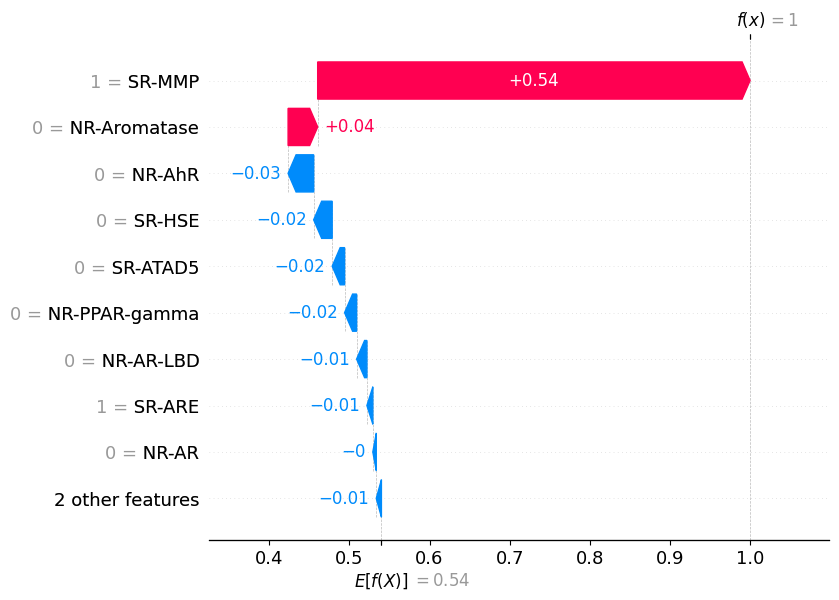

In [47]:
# compute shap values
shap_calc = ShapValues()
shap_calc.fit(train_dataset, model)
shap_calc.sample_explanation_plot(index=1, plot_type='waterfall')

In [74]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 66
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi_conv, patt_number)

Prediction:  0
Actual Value:  0.0
2024-05-17 22:14:41,509 — INFO — Pattern does not match molecule! Active bits: [ 90  91 104 123 129 131 132 136 139 140 146 154 155 157 159 164]


2024-05-17 22:51:15,038 — INFO — Bit 80 with 2 hits!


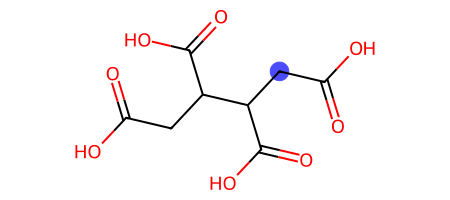

In [84]:
patt_number = 80
MorganFingerprint().draw_bit(smi_conv, patt_number)

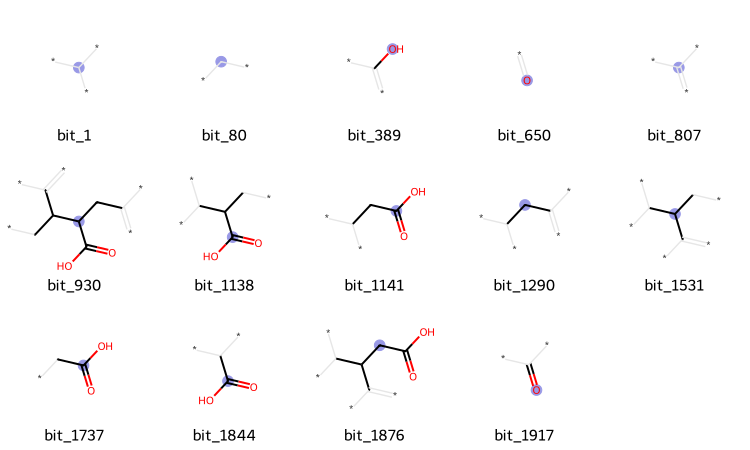

In [79]:
MorganFingerprint().draw_bits(smi_conv, [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])

In [75]:
patt_number = 112 
mol_number = 2

prediction = model.predict(test_dataset)[mol_number]
actual_value = test_dataset.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_dataset.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi, patt_number)

Prediction:  0.0
Actual Value:  0.0
2024-05-17 22:14:48,170 — INFO — Pattern does not match molecule! Active bits: [ 90  91 104 123 129 131 132 136 139 140 146 154 155 157 159 164]


2024-05-17 22:16:24,119 — INFO — Bit 1 with 2 hits!


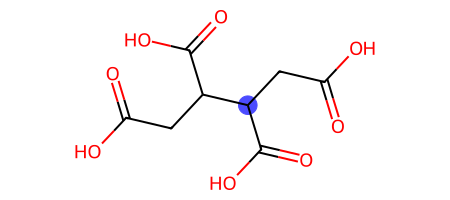

In [83]:
patt_number = 1
MorganFingerprint().draw_bit(smi, patt_number)

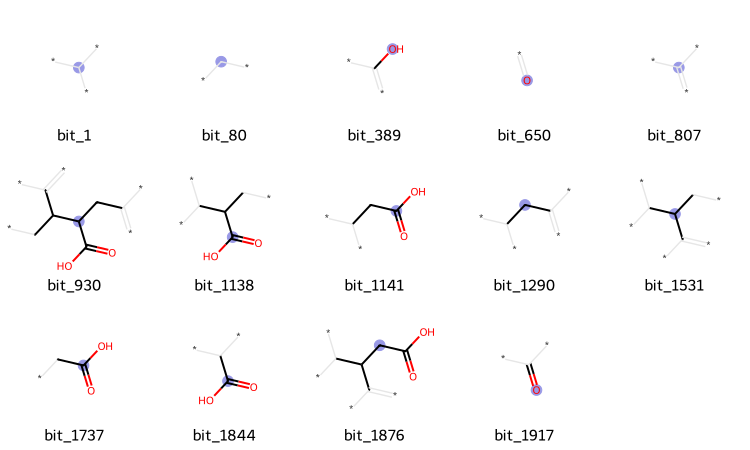

In [81]:
MorganFingerprint().draw_bits(smi,  [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])